<a href="https://colab.research.google.com/github/SummerToday/AI_Project/blob/main/manandgirl(real)(500%2C100).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import os
import time
import copy
import glob
import cv2
import shutil

import torchvision.models as models

import torch.optim as optim
import torch
import torchvision.datasets as datasets
import torch.optim.lr_scheduler as lr_scheduler


from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()   # 데이터 불러오기: chap05/data/menandgirl.zip 파일 선택

Saving manandgirl.zip to manandgirl.zip


In [3]:
!unzip manandgirl.zip -d manandgirl/    #menandgirl 폴더 만들어 압축 풀기

Archive:  manandgirl.zip
   creating: manandgirl/manandgirl/
   creating: manandgirl/manandgirl/test/
   creating: manandgirl/manandgirl/test/girl/
  inflating: manandgirl/manandgirl/test/girl/112944.jpg.jpg  
  inflating: manandgirl/manandgirl/test/girl/112950.jpg.jpg  
  inflating: manandgirl/manandgirl/test/girl/112953.jpg.jpg  
  inflating: manandgirl/manandgirl/test/girl/112956.jpg.jpg  
  inflating: manandgirl/manandgirl/test/girl/112959.jpg.jpg  
  inflating: manandgirl/manandgirl/test/girl/112961.jpg.jpg  
  inflating: manandgirl/manandgirl/test/girl/112967.jpg.jpg  
  inflating: manandgirl/manandgirl/test/girl/112968.jpg.jpg  
  inflating: manandgirl/manandgirl/test/girl/112970.jpg.jpg  
  inflating: manandgirl/manandgirl/test/girl/112973.jpg.jpg  
  inflating: manandgirl/manandgirl/test/girl/112974.jpg.jpg  
  inflating: manandgirl/manandgirl/test/girl/112979.jpg.jpg  
  inflating: manandgirl/manandgirl/test/girl/112987.jpg.jpg  
  inflating: manandgirl/manandgirl/test/girl/1

이미지 데이터셋의 RGB 채널의 평균 값과 표준 편차 값을 계산하기 위한 함수

In [4]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch

# 이미지 데이터셋의 RGB 채널의 평균 값과 표준 편차 값을 계산하는 함수
def calculate_mean_std(data_dir):
    dataset = datasets.ImageFolder(root=data_dir, transform=transforms.ToTensor())
    loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
    
    mean_R, mean_G, mean_B = 0, 0, 0
    std_R, std_G, std_B = 0, 0, 0
    total_images = 0
    
    for images, _ in loader:
        batch_size = images.size(0)
        total_images += batch_size
        mean_R += torch.mean(images[:, 0, :, :])
        mean_G += torch.mean(images[:, 1, :, :])
        mean_B += torch.mean(images[:, 2, :, :])
        
        std_R += torch.std(images[:, 0, :, :])
        std_G += torch.std(images[:, 1, :, :])
        std_B += torch.std(images[:, 2, :, :])
    
    mean_R /= total_images
    mean_G /= total_images
    mean_B /= total_images
    
    std_R /= total_images
    std_G /= total_images
    std_B /= total_images
    
    return [mean_R.item(), mean_G.item(), mean_B.item()], [std_R.item(), std_G.item(), std_B.item()]

# 이미지 데이터셋의 경로
data_dir = 'manandgirl/manandgirl'  # 상대 경로

# 평균 값과 표준 편차 계산
mean_values, std_values = calculate_mean_std(data_dir)

print("RGB 평균 값:", mean_values)
print("RGB 표준 편차 값:", std_values)


RGB 평균 값: [0.6523783206939697, 0.4830118715763092, 0.40417540073394775]
RGB 표준 편차 값: [0.20592018961906433, 0.1788422167301178, 0.16693346202373505]


In [5]:

# 검증을 위한 일반화
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize([256, 256]),
        # 이미지 크기를 256x256 픽셀로 조정합니다.
        transforms.RandomResizedCrop(224),
        # 임의의 위치와 크기에서 224x224 픽셀로 잘라내어 크롭합니다.
        transforms.RandomHorizontalFlip(),
        # 50%의 확률로 이미지를 수평으로 뒤집습니다.
        transforms.ToTensor(),
        # 이미지를 텐서로 변환합니다.
        transforms.Normalize(mean_values, std_values)
        # 이미지를 정규화합니다. 입력 이미지의 RGB 채널 값을 정규화합니다.
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        # 이미지 크기를 224x224 픽셀로 조정합니다.
        transforms.CenterCrop(224),
        # 이미지의 중앙 부분을 224x224 픽셀로 잘라냅니다.
        transforms.ToTensor(),
        # 이미지를 텐서로 변환합니다.
        transforms.Normalize(mean_values, std_values)
        # 이미지를 정규화합니다. 입력 이미지의 RGB 채널 값을 정규화합니다.
    ])
} #위의 코드는 데이터 변환(transform)을 정의하는 부분입니다. 
#데이터 변환은 입력 이미지에 대해 수행되는 여러 가지 전처리 작업을 의미합니다. 
#이러한 전처리 작업은 데이터의 특성을 고려하여 모델 학습을 개선하고 
#일반화 성능을 향상시키는 데 도움을 줍니다.
#transforms.Normalize는 입력 이미지의 RGB 채널 값을 평균과 표준 편차로 조정하여
# 모델이 더 나은 성능을 발휘할 수 있도록 도와줍니다.

data_dir = 'manandgirl/manandgirl'  # 상대 경로

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
#위의 코드는 데이터셋을 로드하는 부분입니다. datasets.ImageFolder를 사용하여 
#data_dir 경로에서 이미지 데이터셋을 로드합니다. 
#x는 'train' 또는 'test'를 가리키며, 해당 경로에 있는 이미지들을 
#data_transforms[x]에 지정된 전처리 방식으로 변환합니다.  

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
                  for x in ['train', 'test']}
#위의 코드는 데이터셋을 미니배치로 나누어 로드하는 부분입니다. 
#torch.utils.data.DataLoader를 사용하여 image_datasets[x] 데이터셋을 
#미니배치로 나누어 로드합니다. 
#batch_size는 한 번에 로드할 미니배치의 크기를 의미하며, 
#shuffle=True는 데이터를 섞어 로드하도록 지정한 것입니다. 
#num_workers는 데이터 로딩을 병렬로 처리할 스레드의 개수를 나타냅니다.

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes
#위의 코드는 데이터셋의 크기와 클래스 이름을 저장하는 부분입니다. 
#len(image_datasets[x])는 데이터셋 x의 샘플 개수를 계산하여 저장합니다. 
#image_datasets['train'].classes는 학습 데이터셋의 클래스 이름을 저장합니다.


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#위의 코드는 딥러닝 모델을 실행할 장치를 설정하는 부분입니다. 
#torch.cuda.is_available() 함수를 사용하여 CUDA가 사용 가능한 경우 
#GPU(쿠다)를 사용하도록 설정하고, 그렇지 않은 경우 CPU를 사용하도록 설정합니다. 
#이 설정은 모델의 학습과 추론에 사용할 장치를 결정하는데 사용됩니다.

device #선택된 장치 출력.

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


device(type='cpu')

<학습 데이터의 배치의 시각화>

> 학습 데이터의 배치를 이미지로 시각화하는 것은 데이터가 모델에 올바르게 입력되는지 확인하는 데 도움을 줍니다. 시각화를 통해 데이터의 전반적인 특징과 레이블링이 올바른지, 이미지가 올바르게 전처리되었는지 확인할 수 있습니다.



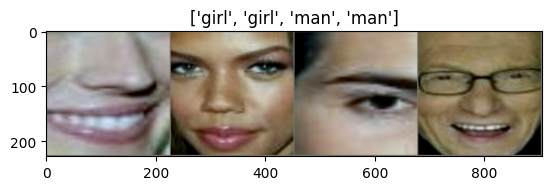

In [6]:
def imshow(inp, title=None):
    """텐서를 위한 imshow 함수입니다."""

    # 입력 텐서를 NumPy 배열로 변환하고 차원을 전치합니다.
    inp = inp.numpy().transpose((1, 2, 0))
    # 정규화를 위한 평균과 표준 편차 값을 정의합니다.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    # 입력 텐서를 평균과 표준 편차를 이용하여 정규화합니다.
    inp = std * inp + mean
    # 입력 텐서의 값을 0과 1 사이로 클리핑합니다.
    inp = np.clip(inp, 0, 1)
    # 이미지를 표시합니다.
    plt.imshow(inp)
    # 제목이 주어진 경우 제목을 추가합니다.
    if title is not None:
        plt.title(title)
    # 잠시 기다리면서 업데이트될 때까지 그래프를 유지합니다.
    plt.pause(0.001)

# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

# imshow 함수를 사용하여 이미지를 표시합니다.
imshow(out, title=[class_names[x] for x in classes])


In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)

    # 결과 시각화
    plot_training_results(train_losses, val_losses, train_accs, val_accs)

    return model


In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [9]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_ft.fc = nn.Linear(num_ftrs, 2)


model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 65.7MB/s]


In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.7513 Acc: 0.6540
test Loss: 0.4087 Acc: 0.7900

Epoch 1/9
----------
train Loss: 0.6080 Acc: 0.7390
test Loss: 0.2978 Acc: 0.8950

Epoch 2/9
----------
train Loss: 0.5764 Acc: 0.7640
test Loss: 0.3251 Acc: 0.9050

Epoch 3/9
----------
train Loss: 0.6012 Acc: 0.7530
test Loss: 0.2485 Acc: 0.9250

Epoch 4/9
----------
train Loss: 0.4956 Acc: 0.8010
test Loss: 0.2836 Acc: 0.9300

Epoch 5/9
----------
train Loss: 0.4907 Acc: 0.7940
test Loss: 0.2341 Acc: 0.9250

Epoch 6/9
----------
train Loss: 0.4689 Acc: 0.8140
test Loss: 0.2039 Acc: 0.9450

Epoch 7/9
----------
train Loss: 0.3302 Acc: 0.8440
test Loss: 0.2019 Acc: 0.9400

Epoch 8/9
----------
train Loss: 0.3180 Acc: 0.8580
test Loss: 0.2012 Acc: 0.9400

Epoch 9/9
----------
train Loss: 0.3125 Acc: 0.8610
test Loss: 0.1895 Acc: 0.9450

Training complete in 49m 46s
Best val Acc: 0.945000


NameError: ignored

In [11]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * (np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)))
    image = image.clip(0, 1)
    return image


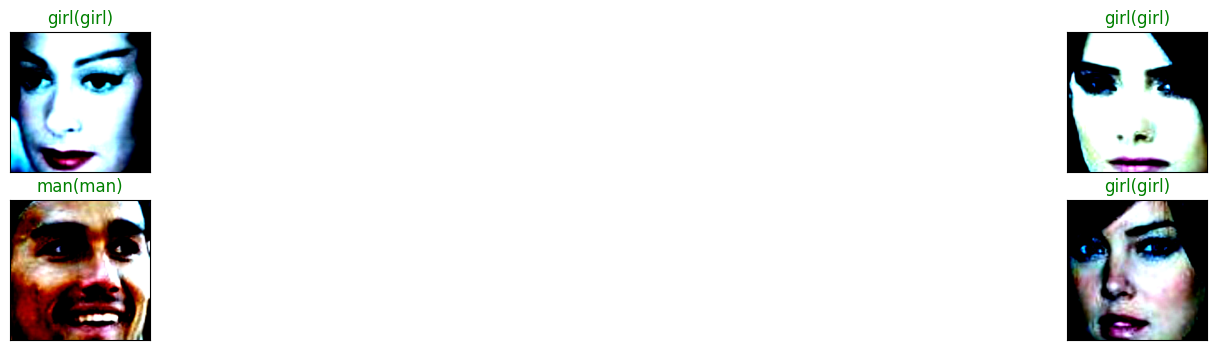

<Figure size 640x480 with 0 Axes>

In [12]:
classes = {0: 'girl', 1: 'man'}

images, labels = next(iter(dataloaders['test']))
images = images.to(device)
output = model_ft(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))
num_images = len(images)
num_cols = int(num_images/2)  # 이미지 수를 반으로 나누어 열의 수 계산

for idx in np.arange(num_images):
    ax = fig.add_subplot(2, num_cols, idx + 1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])),
                 color=("green" if preds[idx] == labels[idx] else "red"))

plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)
#dataloaders의 batch size가 4이기 때문에 4개 출력.

In [13]:
from torchsummary import summary

# 모델 구조 출력
summary(model_ft, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [14]:
actual = []
deep_features = []

model_ft.eval()
with torch.no_grad():
    for data in dataloaders['test']:
        images, labels = data[0].to(device), data[1].to(device)
        features = model_ft(images)

        deep_features += features.cpu().numpy().tolist()
        actual += labels.cpu().numpy().tolist()

In [15]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
cluster = np.array(tsne.fit_transform(np.array(deep_features)))
actual = np.array(actual)

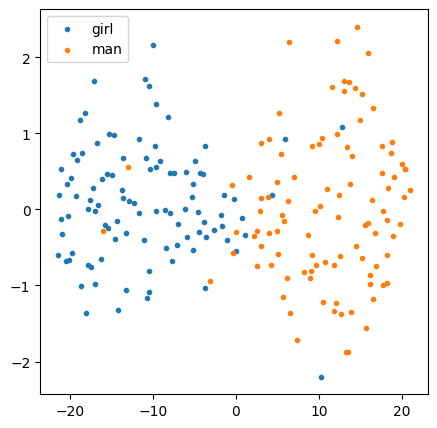

In [16]:
plt.figure(figsize=(5, 5))
name = ['girl', 'man']
for i, label in zip(range(2), name):
    idx = np.where(actual == i)
    plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=label)

plt.legend()
plt.show()